# Разработка A/B-тестирования и анализ результатов

- Автор: Смирнова Анастасия
- Дата: 06.04.2025

<font color='#0b5394'>**Цель проекта** - провести исследовательский анализ  и рассчитать параметры A/B-теста, который позволит проверить эффективность разработанного алгоритма рекоммендаций для развлекательного приложения с функцией "бесконечной ленты".
**Задачи проекта**:

- Поработать с историческими данными. Проанализировать число регистраций, число просмотренных страниц, найти долю пользователей, которые просмотрели более четырех страниц;
- Подготвоиться к тесту. Рассчитать размер выборки и длительность A/B-теста;
- Провести мониторинг A/B-теста. Проверить распределение пользователей, независимость получившихся выборок, оценить равномерность распределения пользователей по основным категориальным переменным.
- Проверить результаты проведенного теста и оценить эффективность нового алгоритма рекоммендаций.
</font>

## Описание данных

<font color='#0b5394'>Данные содержатся в трех таблицах:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.
- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.
- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`. </font>

<font color='#0b5394'>У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

<font color='#0b5394'>Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;
- `session_id` — идентификатор сессии в приложении;
- `session_date` — дата сессии;
- `session_start_ts` — дата и время начала сессии;
- `install_date` — дата установки приложения;
- `session_number` — порядковый номер сессии для конкретного пользователя;
- `registration_flag` — является ли пользователь зарегистрированным;
- `page_counter` — количество просмотренных страниц во время сессии;
- `region` — регион пользователя;
- `device` — тип устройства пользователя;
- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет). </font>

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных

<font color='#0b5394'>Cчитаем и сохраним в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

In [ ]:
#импортируем необходимые библиотеки
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter

import numpy as np

In [ ]:
#загружаем датасет с историческими данными о сессиях пользователей
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

#выводим первые пять строк датафрейма sessions_history
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

<font color='#0b5394'> Рассчитаем количество уникальных сессий каждого пользователя, предварительно проверив необходимые для расчета столбцы на наличие дубликатов и пропусков. Для проведения расчетов воспользуемся методами `isna()`,`duplicated()` в сочетании с `sum()`

<font color='#0b5394'> Для начала проверим датафрейм `sessions_history` на наличие пропусков в столбцах `user_id` и `session_id`.

In [ ]:
#рассчитаем колчичество пропусков в столбцах user_id и session_id
empty_values = sessions_history[['user_id','session_id']].isna().sum()

print('Количество пропущенных значений в столбцах `user_id` и `session_id` датафрейма sessions_history:')
empty_values

Количество пропущенных значений в столбцах `user_id` и `session_id` датафрейма sessions_history:


,0
user_id,0
session_id,0


<font color='#0b5394'>Пропущенных значений в столбцах `user_id` и `sessions_id` нет. Это значит, что информация о сессиях пользователей полная. Далее проверим датафрейм `sessions_history` на наличие полных дубликатов.

In [ ]:
#рассчитаем количество полных дубликатов
full_diplicates = sessions_history.duplicated().sum()

print(f'Количество полных дубликатов в датафрейме sessions_history: {full_diplicates}')

Количество полных дубликатов в датафрейме sessions_history: 0


<font color='#0b5394'> Полных дубликатов в датафрейме `sessions_history` нет. Следующим этапом проверим на уникальность значения в столбце `user_id`.

In [ ]:
#рассчитаем количество дубликатов в столбце user_id
user_id_duplicates = sessions_history.duplicated(subset = 'user_id').sum()

user_id_duplicates_share = round(user_id_duplicates / len(sessions_history) * 100,2)

print(f'Количество дубликатов в столбце user_id датафрейма sessions_history: {user_id_duplicates}')
print(f'Доля повторяющихся значений в столбце user_id датафрейма sessions_history: {user_id_duplicates_share}%')

Количество дубликатов в столбце user_id датафрейма sessions_history: 301885
Доля повторяющихся значений в столбце user_id датафрейма sessions_history: 69.25%


<font color='#0b5394'> В столбце `user_id` около 69% значений повторяются. Это свидетельствует о том, что на одного пользователя как правило приходится более одной сессии, что допустимо. Далее проверим, встречабтся ли дубликаты в столбце `session_id`.

In [ ]:
#рассчитаем количество дубликатов в столбце session_id
session_id_duplicates = sessions_history.duplicated(subset = 'session_id').sum()

print(f'Количество дубликатов в столбце user_id датафрейма sessions_history: {session_id_duplicates}')

Количество дубликатов в столбце user_id датафрейма sessions_history: 0


<font color='#0b5394'> Значения в столбце  `session_id` уникальны. Это свидетельствует о том, что в датафрейме содержатся записи только об уникальных сессиях каждого пользователя. Основываясь на полученных результатах можем применить методом `groupby()` в сочетании с `count` для нахождения количества уникальных сессий для каждого пользователя.

In [ ]:
#рассчитываем количество уникальных сессий для каждого пользователя
sessions_count_by_user = sessions_history.groupby('user_id')['session_id'].count().reset_index()

<font color='#0b5394'> Теперь определим пользователей с максимальным количеством сессий.

In [ ]:
#находим и выводим информацию о максимальном количестве сессий
max_count_id = sessions_count_by_user[(sessions_count_by_user['session_id'] == sessions_count_by_user['session_id'].max())]

max_count_id.reset_index(drop=True)

,user_id,session_id
0,10E0DEFC1ABDBBE0,10
1,6A73CB5566BB494D,10


<font color='#0b5394'> Максимальное количество сессий на пользователя - 10. При этом в датафрейме `sessions_history` таких пользователей два. Выберем одного из них и изучим полную информацию о нем в датафрейме `sessions_history`.

In [ ]:
#оставляем запись об одном из пользователей
max_count_id = max_count_id.head(1)

#сохраняем информацию в срез user_info
user_info = sessions_history[(sessions_history['user_id'].isin(max_count_id['user_id']))].copy()

<font color='#0b5394'> Изучим представление данных в полученном срезе при помощи `dtypes`.

In [ ]:
#выводим информацию данных при помощи dtypes
user_info.dtypes

,0
user_id,object
session_id,object
session_date,object
session_start_ts,object
install_date,object
session_number,int64
registration_flag,int64
page_counter,int64
region,object
device,object


In [ ]:
#выводим срез
user_info.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android


<font color='#0b5394'> В датафрейме `sessions_history` данные представлены несколькими типами:

- В столбцах `user_id`, `session_id`, `session_date`, `session_start_ts`, `install_date`, `region`, `device` данные прдеставлены типом `object`. Так как среди данных столбцов есть даты, необходимо выполнить преобразование к типу `datetime64` для удобства расчетов. Также важно, что представление данных в столбце `session_start_ts` отличается от остальных столбцов, содержащих информацию о датах, так как содержит информацию о времени. Необходимо учесть это при преобразовании типа данных;
- В столбцах `session_number` `registration_flag` и  `page_counter` данные представлены типом `int64`. Тип данных подобран корректно, однако для оптимизации необходимо выполнитьт понижение разрядности в данных столбцах. </font>

<font color='#0b5394'> Выполним преобразование типа данных в столбцах `session_date`, `install_date` при помощи метода  `to_datetime()`.

In [ ]:
#Выполянем преобразование
for column in sessions_history[['session_date','install_date']]:
    sessions_history[column] = pd.to_datetime(sessions_history[column], format = '%Y-%m-%d')

#Проверяем успешность преобразования
sessions_history[['session_date','install_date']].dtypes

,0
session_date,datetime64[ns]
install_date,datetime64[ns]


<font color='#0b5394'> Преобразование выполнено успешно. Теперь выполним преобразование в столбце `session_start_ts` с сохранением информации о времени.

In [ ]:
#проводим преобразование
sessions_history['session_start_ts'] = pd.to_datetime(sessions_history['session_start_ts'], format = '%Y-%m-%d %H:%M:%S')

#проверяем корректность преобразования
sessions_history['session_start_ts']

,session_start_ts
0,2025-08-15 17:47:35
1,2025-08-15 16:42:14
2,2025-08-15 12:30:00
3,2025-08-15 15:31:31
4,2025-08-15 21:33:53
...,...
435919,2025-09-17 21:33:57
435920,2025-09-17 17:11:46
435921,2025-09-17 19:36:55
435922,2025-09-17 22:13:33


<font color='#0b5394'> Преобразование выполнено успешно. Информацию о времени начала сессии сохранена.

<font color='#0b5394'> Следующим этапом выполним понижение разрядности в столбцах, содержащих целочисленные данные. Для этого воспользуемся методом `pd.numeric()` с указанием параметра `downcast`. Автоматизируем данный процесс при помощи написания функции. В теле функции также пропишем условие для понижения разрядности для типа данных `float64`. Это сделает функцию более универсальной

In [ ]:
#создаём функцию
def downcast(df):
    """
    Выполняет понижение разрядности в столбцах датафрейма с типами данных
    int64 и float64

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    for dtype, column in zip(df.dtypes, df.columns):
        if dtype == 'int64':
            df[column] = pd.to_numeric(df[column], downcast = 'integer')
        elif dtype == 'float64':
            df[column] = pd.to_numeric(df[column], downcast = 'float')
    print('Результат понижения разрядности:')
    print('')
    return df.info()

In [ ]:
#применяем фукнцию
downcast(sessions_history)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int8          
 6   registration_flag  435924 non-null  int8          
 7   page_counter       435924 non-null  int8          
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](3), int8(3), object(4)
memory usage: 24.5+ MB


<font color='#0b5394'> Понижение разрядности выполнено успешно. Таким образом, преобразования типов данных завершены.

<font color='#0b5394'>В результате предварительного анализа датафрейма `sessions_history` было выявлено следующее:

- Датафрейм содержит инфорацию об уникальных сессиях пользователей. При этом на одного пользователея может приходится более одной сессии, но все идентификаторы сессий - уникальные;
- В датафрейме отсутствуют пропуски по полям `user_id` и `session_id`, что делает возможным проведение расчетов по данным полям без дополнительной обработки;
- Максимальное количество сессий на пользователя - 10. В датафрейме встречается два таких пользователя;
- Данные представлены двумя типами -  `object` и `int64`. Так как некоторые столбцы содержат информацию о датах, были выполнены дополнительные преобразования к типу `datetime64`. Также для оптимизации было выполнено понижение разрядности в столбцах, содержащих целочисленные данные.</font>

#### 1.3. Анализ числа регистраций

<font color='#0b5394'> Рассмотрим, как менялось число регистраций в приложении за время его существования.

<font color='#0b5394'>Для этого найдем число уникальных пользователей и число зарегистрированных пользователей. Данные показатели можно рассчитать путем нахождения количества уникальных значений в столбце `user_id` и суммы по столбцу `registration_flag`

<font color='#0b5394'> Отдельно рассчитаем динамику доли зарегистрированных пользователей по дням. Визуализируем результат при помощи линейных графиков.

In [ ]:
#рассчитываем количество уникальных пользователей и количество зарегистрированных пользователей
users_count = sessions_history.groupby('session_date').agg({'user_id' : pd.Series.nunique,
                                                            'registration_flag' : 'sum'}).reset_index()

#меняем названия столбцов
users_count = users_count.rename(columns = {'user_id' : 'users_total',
                                            'registration_flag': 'registered_users_total'})

#находим долю зарегистрированных пользователей
users_count['registered_users_share'] = users_count['registered_users_total'] / users_count['users_total']

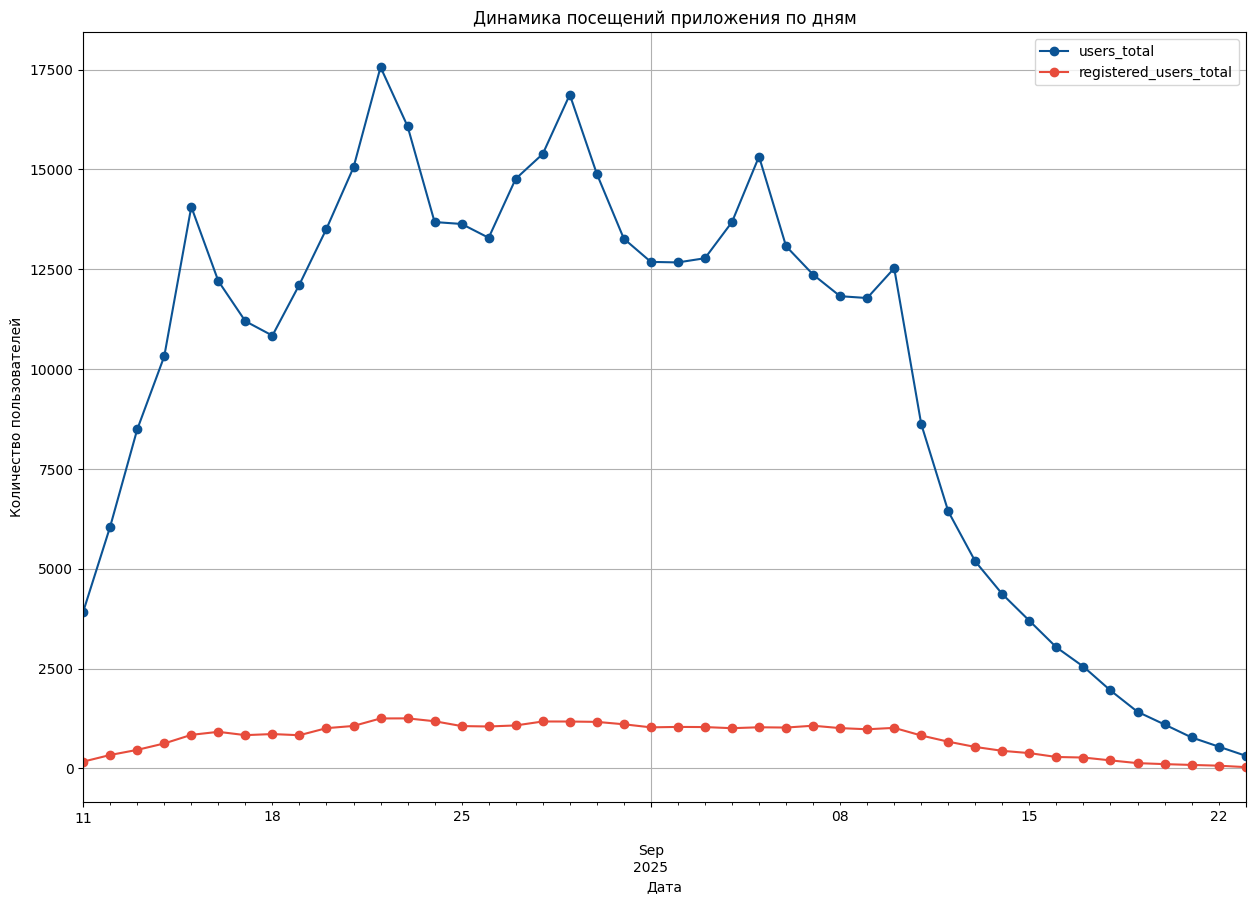

In [ ]:
#строим график
users_count.plot(kind = 'line',
                 x = 'session_date',
                 y = ['users_total','registered_users_total'],
                 title = 'Динамика посещений приложения по дням',
                 ylabel = 'Количество пользователей',
                 xlabel = 'Дата',
                 legend = True,
                 grid = True,
                 figsize = (15,10),
                 marker = 'o',
                 color = ['#0b5394' ,'#e74c3c']
                 )
#выводим график

plt.ticklabel_format(style = 'plain', axis = 'y')

plt.show()

<font color='#0b5394'>Из графика видно, что количество зарегистрированных пользователей, посещавших приложение, менялось незначительно на протяжении наблюдаемого периода. С одной стороны это говорит о том, что количество новых пользователей, проходивших регистрацию росло несущественно. С другой стороны отсутствие колебаний в количестве зарегистрированных пользователей, свидетельствует об их лояльности и регулярном посещении приложения.

<font color='#0b5394'>Общее количество пользователей, посещавщих приложение, изменялось более динамично. Например, в августе видна отчетливая тенденция к увеличнию общего количества пользователей, однако, начиная с сентября количество пользователей идет на спад. При постоянном количестве зарегистрированных пользователей и изменяющемся общем количестве пользователей можно предположить о том, что доля зарегистрированных пользователей, посещавших приложение, менялась динамично.

<font color='#0b5394'>Проверим данное предположение построив еще один график с визуализацией динамики доли зарегистрированных пользователей по дням.

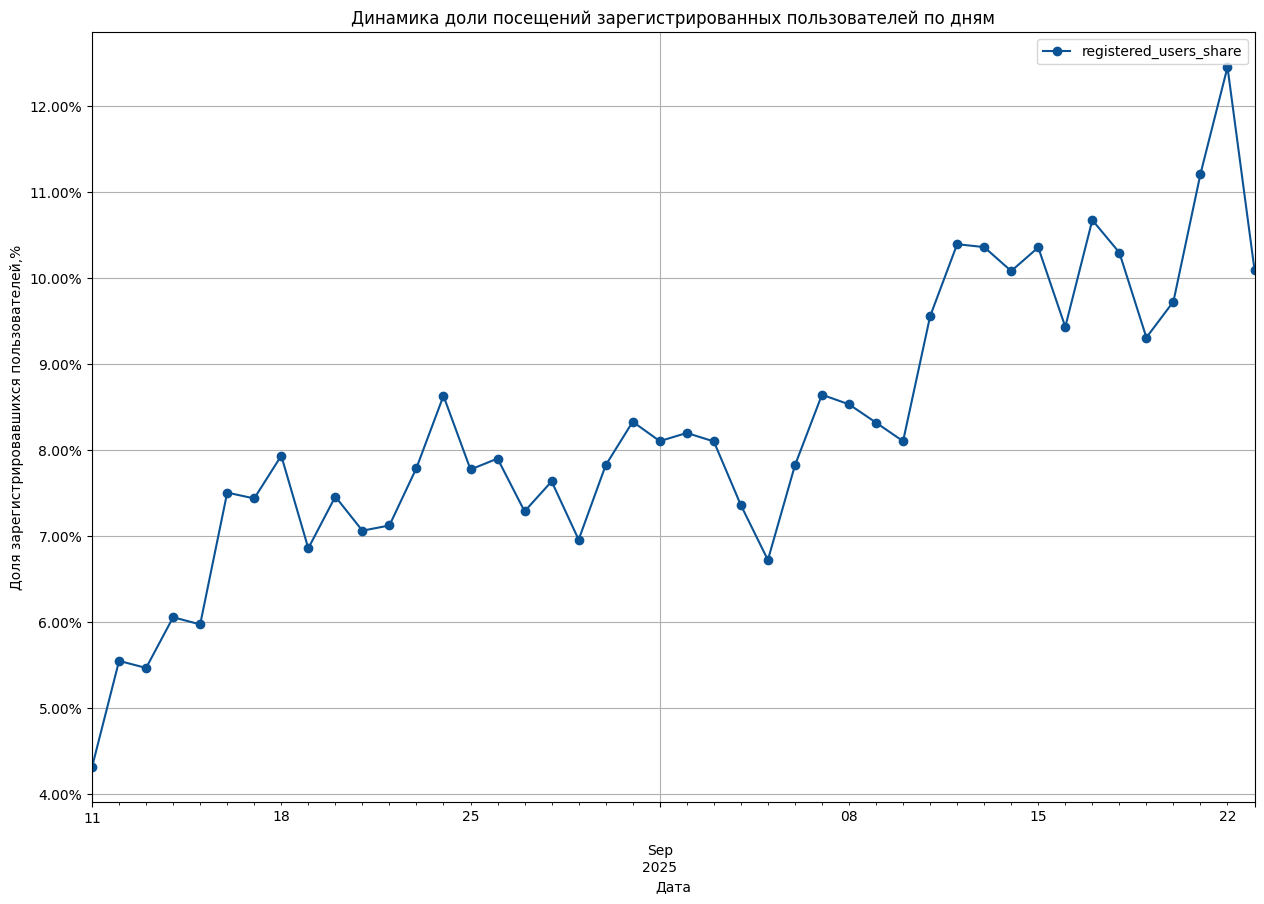

In [ ]:
#строим график
users_count.plot(kind = 'line',
                           x = 'session_date',
                           y = 'registered_users_share',
                           title = 'Динамика доли посещений зарегистрированных пользователей по дням',
                           ylabel = 'Доля зарегистрировавшихся пользователей,%',
                           xlabel = 'Дата',
                           legend = True,
                           grid = True,
                           figsize = (15,10),
                           marker = 'o',
                           color = '#0b5394'
                          )
#выводим график

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2, symbol='%'))

plt.show()

<font color='#0b5394'>Действительно, изменение доли зарегистрированных пользователей от общего количество пользователей, посетивших приложение, более динамично.

<font color='#0b5394'>Из-за того что в сентябре наблюдается заметное снижение общего количества пользователей при незначительно изменившемся количестве зарегистрированных пользователей, мы наблюдаем рост доли зарегистрированных пользователей, посетивших приложение.

<font color='#0b5394'>На основании полученных данных можно сделать два вывода:
- С одной стороны существует положительная тенденция по вовлеченности зарегистрированных пользователей. Количество зарегистрированных пользователей на протяжении всего рассматриваемого периода является достаточно постоянным. Это говорит о том, что пользователи регулярно посещают прилоежние;
- C другой стороны видна тенденция к снижению общего количества пользователей, посетивших приложение. Об этом также свидетельствует и рост доли зарегистрированных пользоватателей.</font>

#### 1.4. Анализ числа просмотренных страниц

<font color='#0b5394'> Проанализируем число просмотренных страниц в приложении. Для этого рассчитаем количество сессий - `session_id`, соответствующее каждому значению количества просмотренных страниц - `page_counter`. Получившийся результат визуализиурем в виде столбчатой диаграммы.

In [ ]:
#выполняем агрегацию данных
sessions_count_by_pages = sessions_history.groupby('page_counter')['session_id'].count().reset_index()

sessions_count_by_pages = sessions_count_by_pages.rename(columns = {'session_id' : 'sessions_count'})

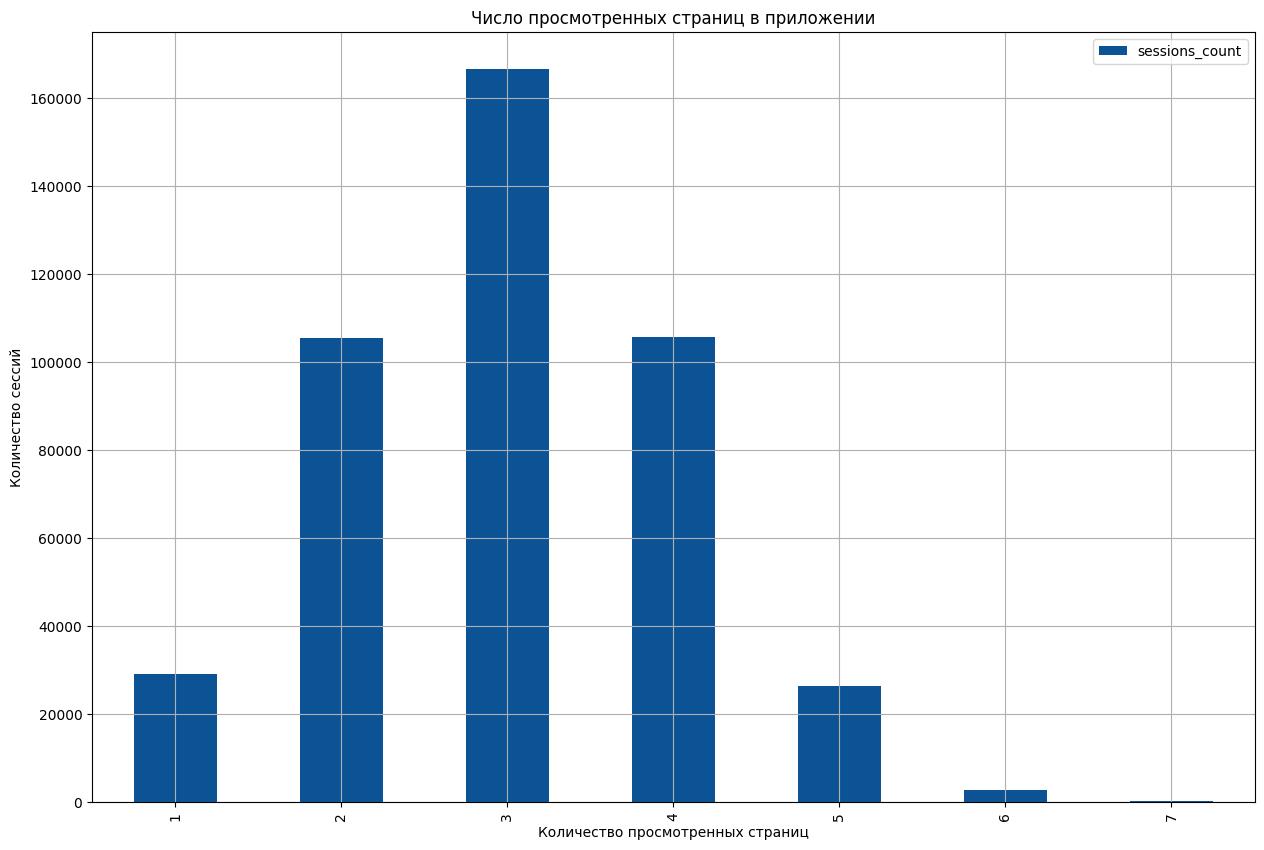

In [ ]:
#строим диаграмму
sessions_count_by_pages.plot(kind = 'bar',
                           x = 'page_counter',
                           y = 'sessions_count',
                           title = 'Число просмотренных страниц в приложении',
                           ylabel = 'Количество сессий',
                           xlabel = 'Количество просмотренных страниц',
                           legend = True,
                           grid = True,
                           figsize = (15,10),
                           color = '#0b5394'
                         )
#отображаем диаграмму
plt.show()

<font color='#0b5394'>  На диаграмме видно, что наиболее частое количество просмотренных страниц в рамках одной сессии - 3. Примерно одинаковое количество сессий приходится на 2 и 4 страницы, а также на 1 и 5 страниц. 6 или 7 страниц в рамках одной сессии просматривает гораздо меньшее количество пользователей.

<font color='#0b5394'>  Такие результаты говорят о том, что у пользователей приложения есть некоторая вовлеченность в контенет, однако после достижения трех страниц, вовлеченность начинает снижаться. Необходимо проанализировать причины таких показателей детально для того, чтобы разработать меры по повышению удежания пользователей в приложении.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

<font color='#0b5394'>Рассчитаем среднее значение доли успешных сессий за каждый день наблюдаемого периода. Успешной сессию будем считать в случае, если количество просмотренных страниц в рамках такой сессии больше или равно 4.

<font color='#0b5394'> Для этого введем дополнительный столбец с булевым признаком. Для создания столбца создадим функцию `good_session`.

In [ ]:
#создаем функцию
def good_session(df):
    """
    Создает столбец с признаком good_session

    Parameters:
        df (name of pd.DataFrame): Датафрейм для обработки.
    """
    if df['page_counter'] >= 4:
        return 1
    else:
        return 0

In [ ]:
#применяем функцию
sessions_history['good_session'] = sessions_history.apply(good_session,axis = 1)

In [ ]:
#находим общее количество сессий и количество успешных сессий для каждого пользователя
successful_sessions = sessions_history.groupby(['user_id','session_date']).agg({'session_id': 'count',
                                                                                'good_session' : 'sum'}).reset_index()

#меняем наименования агрегированных столбцов
successful_sessions = successful_sessions.rename(columns = { 'session_id' : 'total_sessions',
                                                             'good_session' : 'good_sessions_total'})
#находим долю успешных сессий каждого пользователя
successful_sessions['good_sessions_share'] = successful_sessions['good_sessions_total'] / successful_sessions['total_sessions']

#находим среднюю долю успешных сессий по дням
successful_sessions = successful_sessions.groupby('session_date')['good_sessions_share'].mean().reset_index()

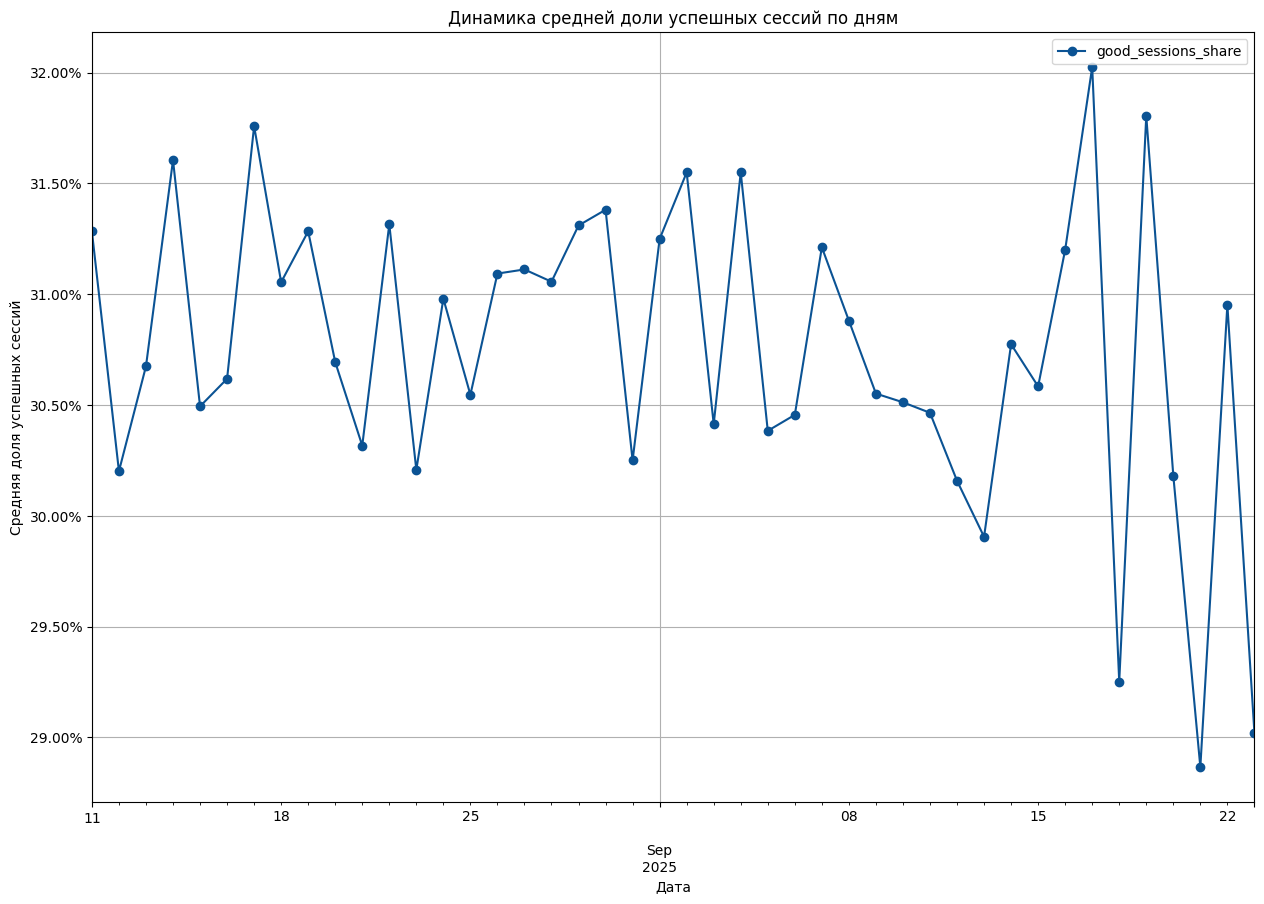

In [ ]:
#строим график
visual = successful_sessions.plot(kind = 'line',
                           x = 'session_date',
                           y = 'good_sessions_share',
                           title = 'Динамика средней доли успешных сессий по дням',
                           ylabel = 'Средняя доля успешных сессий',
                           xlabel = 'Дата',
                           legend = True,
                           grid = True,
                           figsize = (15,10),
                           marker = 'o',
                           color = '#0b5394'
                          )
#выводим график
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2, symbol='%'))

plt.show()

<font color='#0b5394'>На графике видно, что на протяжении наблюдаемого периода средняя доля успешных сессий изменялась в диапазоне от 28% до 33%.

<font color='#0b5394'> При этом в августе доля таких сессий была более постоянна и не проседала ниже 30%, однако начиная с сентября доля таких сессий в первые упала ниже 30%. Ближе к концу наблюдаемого периода доля успешных сессий становится более непостоянной. Возможно алгоритмы рекоммендаций работают недостаточно эффективно для того, чтобы обеспечить постоянную вовлечённсть в контент.

<font color='#0b5394'> Работа с историческими данными позвоила выявить следующее:

- Рост доли зарегистрированных пользователей, посещающих приложение, к концу наблюдаемого периода связан с снижением общего количества пользоваталей, посещающих приложение. С одной стороны существует положительная тенденция по вовлеченности зарегистрированных пользователей. С другой стороны снижение общего количества пользователей, использующих приложение, сигнализирует о возможных проблемах с удержанием новых пользователей и требует дополнительных мер по их удержанию;
- Наиболее частое количество страниц, посещаемых в рамках одной сессии - 3. При этом, начиная с 4-х и более страниц наблюдается снижение общего количества сессий пользователей. Возможно требуется улучшение алгоритма рекоммендаций для повышения вовлеченности пользователей;
- Доля сессий, в рамках которых было просмотрено 4 и более страниц, колеблется в пределах 28% - 33% в течение наблюдаемого преиода. При этом ближе к концу наблюдаемого периода колебание доли таких сессий становится более резким по сравнению с началом. Это также тревожный сигнал, который может говорить о снижении вовлеченности пользователей.</font>

### 2. Подготовка к тесту
<font color='#0b5394'> При планировании теста необходимо проделать несколько важных шагов:

- Определиться с целевой метрикой.
- Рассчитать необходимый размер выборки.
- Исходя из текущих значений трафика, рассчитать необходимую длительность проведения теста. </font>

#### 2.1. Расчёт размера выборки

<font color='#0b5394'> Рассчитаем необходимое для проведения эксперимента количество пользователей. Для этого воспользуемся методом solve_power() из класса power.NormalIndPower модуля statsmodels.stats.

<font color='#0b5394'> Установим следующие параметры для расчета:

- Уровень значимости — 0.05.
- Вероятность ошибки второго рода — 0.2.
- Мощность теста.
- Минимальный детектируемый эффект, или MDE, — 3%. </font>

In [ ]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


<font color='#0b5394'> Таким образом, для успешного проведения эксперимента необходимо набрать 17441 пользователя в каждую из групп. Рассчитаем среднее количество уникальных пользователей в день и на основании этого рассчитаем, какое количество дней примерно потребуется для проведения эксперимента.

#### 2.1. Расчёт длительности A/B-теста


In [ ]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date').agg({'user_id' : pd.Series.nunique}).reset_index()
avg_daily_users = ceil(avg_daily_users['user_id'].mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size * 2/ avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 4 дней


<font color='#0b5394'> При среднем трафике в 9 908 пользователей в день потребуется 4 дня для проведения эксперимента. При этом необходимо отбирать по 4954 пользователя в каждую группу ежедневно. Однако на практике длительность эксперимента может быть увеличена, так как количество пользователей день ото дня может колебаться и иногда быть ниже среднего значения.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

<font color='#0b5394'>На основании данных за первый день эксперимента, проверим корректность разделения пользователей на группы.

<font color='#0b5394'>Для этого сохраним данные о первом дне проведения эксперимента в датафрейм `sessions_test_part` и на основании полученных данных рассчитаем процентную разницу в количестве пользователей в группах A и B.

<font color='#0b5394'>Для расчёта воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [ ]:
#загружаем данные в датасет sessions_test_part
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

#выводим первые пять строк
sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


<font color='#0b5394'> Сгруппируем данные по столбцу `test_group` и рассчитаем количество уникальных пользователей в каждой группе.

In [ ]:
#агрегируем данные
unique_users = sessions_test_part.groupby('test_group').agg({'user_id' : pd.Series.nunique}).reset_index()

#выводим результат
unique_users

,test_group,user_id
0,A,1477
1,B,1466


<font color='#0b5394'> На первый взгляд количество пользователей в каждой из групп различается незначительно. Однако, количество пользователей, собранных для эксперимента за первый день, существенно ниже, чем количество, рассчитанное на основании среднего количества пользователей. Таким образом, длительность эксперимента будет будет увеличена, так как сбор данных происходит не так быстро, как предполагалось.

<font color='#0b5394'> Рассчитаем процентную разницу в группах пользователей A и B, чтобы убедиться в том, что разница незначительна. Для нахождения модуля разницы A и B воспользуемся функцией `fabs()` из модуля `math`.

In [ ]:
#импортируем нужную библиотеку
from math import fabs

A = int(unique_users['user_id'][(unique_users['test_group'] == 'A')].iloc[0])

B = int(unique_users['user_id'][(unique_users['test_group'] == 'B')].iloc[0])

#рассчитываем процентную разницу
p = round(100 * fabs(A - B)/A,2)

print(f'Процентная разница между количество пользователей в группе A и B составляет {p}%')

Процентная разница между количество пользователей в группе A и B составляет 0.74%


<font color='#0b5394'> Визуализируем получившийся результат при помощи линейного графика с разбивкой количества пользователей каждой группы по часам. Для этого выделим новый столбец `starting_hour`.

In [ ]:
#выделяем каждый час в течение рассматриваемого дня
sessions_test_part['starting_hour'] = pd.to_datetime(sessions_test_part['session_start_ts']).dt.hour

#агрегируем данные для визуализации
users_by_hours = sessions_test_part.pivot_table(index = 'starting_hour',
                                                columns = 'test_group',
                                                values = 'user_id',
                                                aggfunc = pd.Series.nunique).reset_index().rename_axis(None, axis=1)


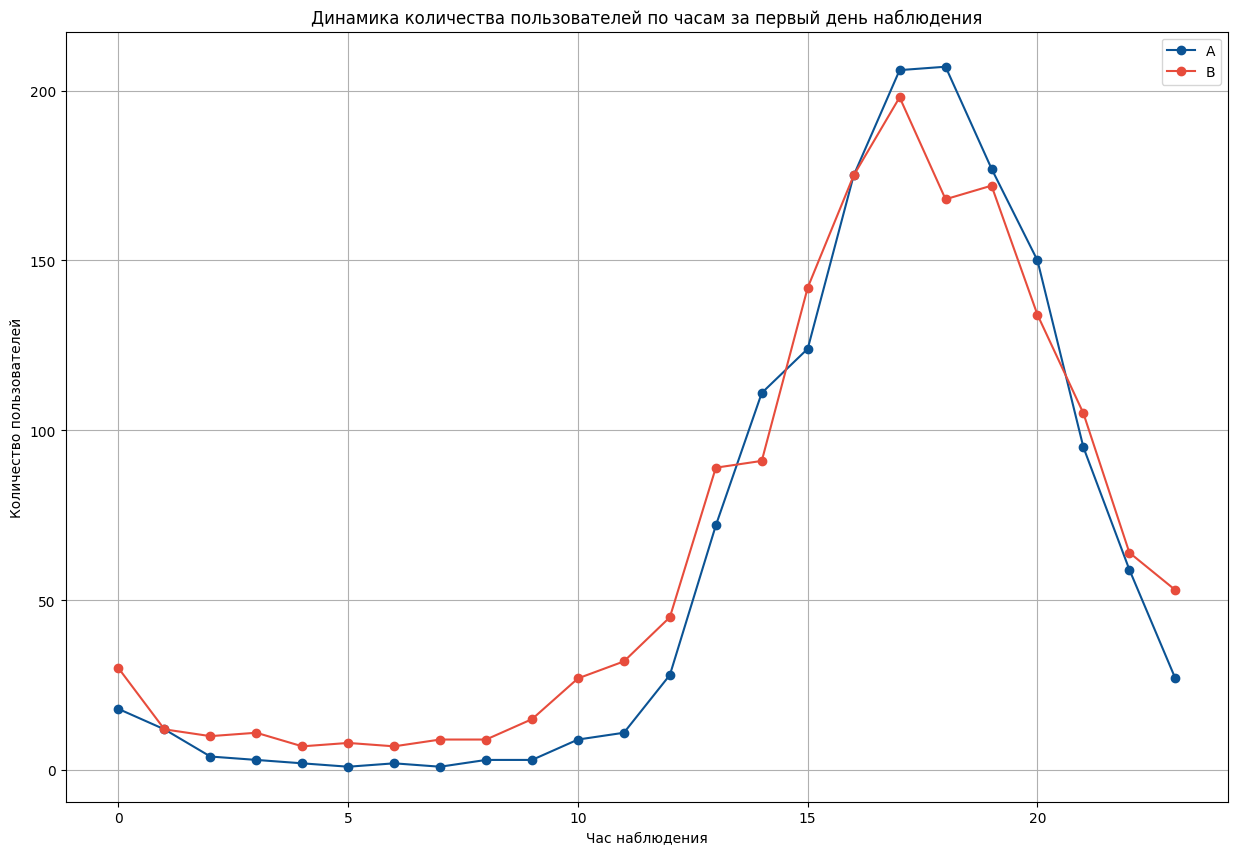

In [ ]:
#строим график
visual = users_by_hours.plot(kind = 'line',
                           x = 'starting_hour',
                           y = ['A','B'],
                           title = 'Динамика количества пользователей по часам за первый день наблюдения',
                           ylabel = 'Количество пользователей',
                           xlabel = 'Час наблюдения',
                           legend = True,
                           grid = True,
                           figsize = (15,10),
                           marker = 'o',
                           color = ['#0b5394','#e74c3c']
                          )
#выводим график

plt.show()

<font color='#0b5394'> Получившаяся процентная разница и линейный график, отражающий динамику активности пользователей по часам в первый день наблюдения, говорят о том, что существенных различий между группами нет. Существует некоторая разница в почасовой динамике, однако различие между группами невелико, и в каждый час наблюдения разрыв между пользователями двух групп незначителен.

#### 3.2. Проверка пересечений пользователей

<font color='#0b5394'> Несмотря на то, что процентная разница между двумя группами несущественная, необходимо проверить не обсуловлена ли она пользователями, которые могли попасть в обе группы.

In [ ]:
#создаем срез каждой группы пользователем
A = sessions_test_part[(sessions_test_part['test_group'] == 'A')]['user_id']
B = sessions_test_part[(sessions_test_part['test_group'] == 'B')]['user_id']

intersection = list(set(A) & set(B))
print(intersection)

[]


<font color='#0b5394'> Пользователей, попавших и в группу A,и в группу B, нет.

#### 3.3. Равномерность разделения пользователей по устройствам

<font color='#0b5394'> Проверим, равномерно ли распределены пользователи по типу устройств между группами. Для этого построим столбчатые диаграммы.

In [ ]:
#агрегиурем данные
users_by_device = sessions_test_part.pivot_table(index = 'device',
                                                 columns = 'test_group',
                                                 values = 'user_id',
                                                 aggfunc = pd.Series.nunique).reset_index().rename_axis(None, axis=1)

users_by_device['A_share'] = users_by_device['A'] / users_by_device['A'].sum()

users_by_device['B_share'] = users_by_device['B'] / users_by_device['B'].sum()

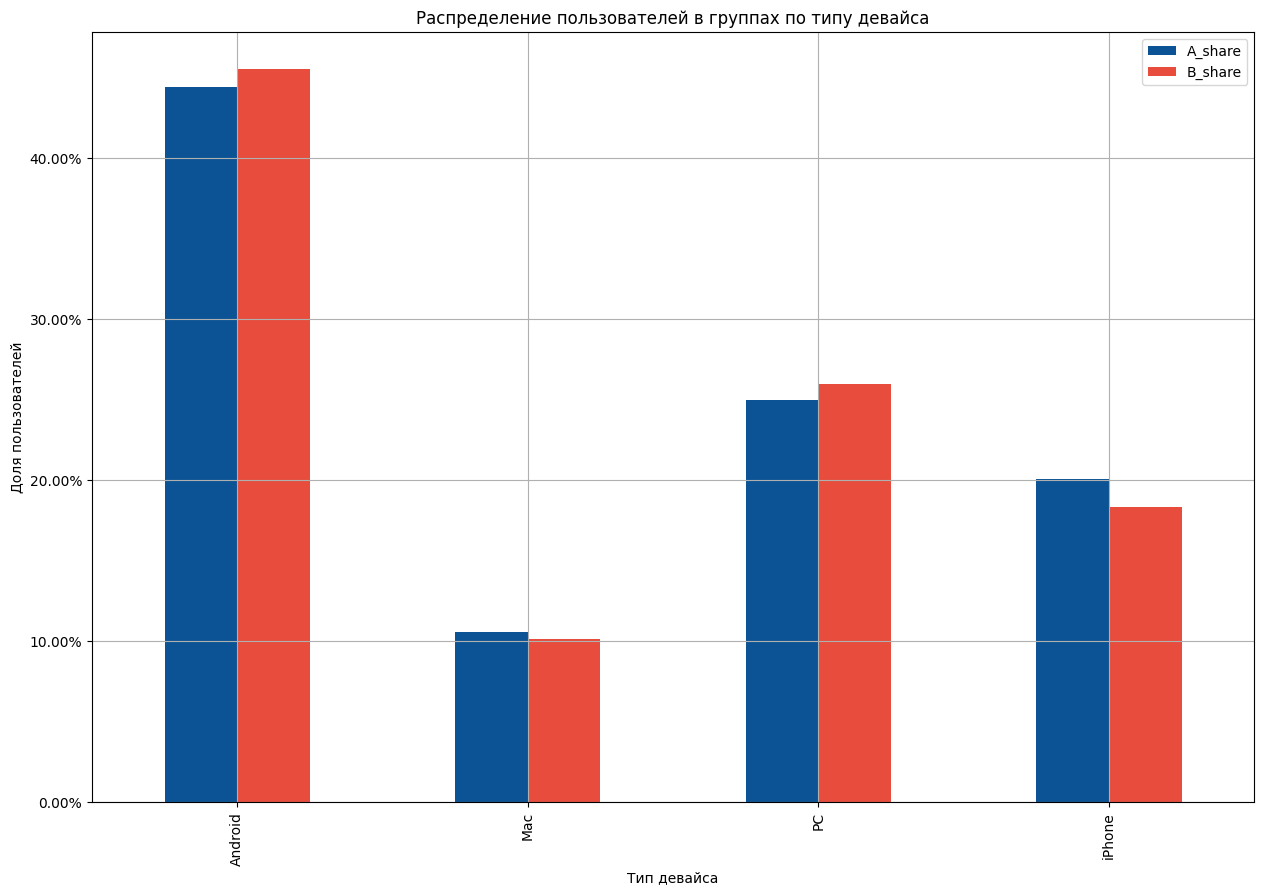

In [ ]:
#строим диаграмму
users_by_device.plot(kind = 'bar',
                           x = 'device',
                           y = ['A_share','B_share'],
                           title = 'Распределение пользователей в группах по типу девайса',
                           ylabel = 'Доля пользователей',
                           xlabel = 'Тип девайса',
                           legend = True,
                           grid = True,
                           figsize = (15,10),
                           color = ['#0b5394','#e74c3c']
                          )
plt.ticklabel_format(style = 'plain', axis = 'y')

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=2, symbol='%'))

plt.show()

<font color='#0b5394'> На диаграмме видно, что распределение пользователей между группами по типу девайса достаточно равномерное. Существуют некоторые различия, однако они несущественны и не повлиют на точность эксперимента.

<font color='#0b5394'> Распределение внутри групп по типу устройств неравномерное. В каждой из групп преобладают пользователи с устройствами на базе Android. Меньше всего пользователей с устройствами на базе Mac.

#### 3.4. Равномерность распределения пользователей по регионам

<font color='#0b5394'> Проверим равномерность распределения пользователей по регионам между группами.

In [ ]:
#агрегиурем данные
users_by_region = sessions_test_part.pivot_table(index = 'region',
                                                 columns = 'test_group',
                                                 values = 'user_id',
                                                 aggfunc = pd.Series.nunique).reset_index().rename_axis(None, axis=1)

users_by_region['A_share'] = users_by_region['A'] / users_by_region['A'].sum()

users_by_region['B_share'] = users_by_region['B'] / users_by_region['B'].sum()

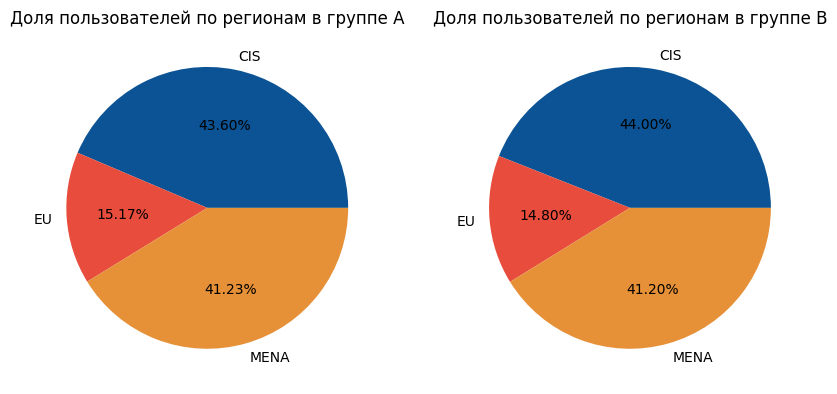

In [ ]:
 #задаем расположение диаграмм рядом
fig, (pie1,pie2) = plt.subplots(1,2,figsize=(10,6))

colors = ['#0b5394','#e74c3c','#e69138']

#задаем параметры для первой диаграммы
labels = users_by_region['region']
values = users_by_region['A_share']
pie1.pie(values,labels = labels,colors = colors,autopct = '%1.2f%%')
pie1.set_title('Доля пользователей по регионам в группе A')

#задаем параметры для второй диаграммы
labels = users_by_region['region']
values = users_by_region['B_share']
pie2.pie(values,labels = labels,colors = colors,autopct ='%1.2f%%')
pie2.set_title('Доля пользователей по регионам в группе B')

#выводим диаграммы
plt.show()

<font color='#0b5394'>Распределение пользователей по регионам внутри групп достаточно равномерное. Наблюдаются незначительные различия, однако они составляют менее 1% по каждому региону и на точность проводимого эксперимента не повлияют. Распределение по регионам внутри групп неравномерное. Очевидно преобладание пользователей из регионов `CIS` и `MENA` в каждой из групп.

#### 3.5. Вывод после проверки A/B-теста

<font color='#0b5394'>На основании проведенного анализа A/B-теста можно сделать следующие выводы:

- Распределение пользователей между группами равномерное. Существует небольшая процентная разница между количеством пользователей, однако она составляет менее 1% и на корректность проводимого теста не повлияет;
- Полученные выборки являются независимыми, пересечение пользователей из тестовой и контрольной группы обнаржуено не было;
- Распределение пользователей между группами по категориальным переменным равномерное. Общая структура каждой из выборок совпадет. </font>

<font color='#0b5394'>На основании полученных данных можно заключить, что A/B-тест проходит корректно. Тем не менее за первый день наблюдений количество пользователей, по которым были собраны данные, существенно отличается от изначально рассчитанных значений на основании среднего трафика. Это говорит о том, что вместо рассчитанных четырех дней, длительность теста будет увеличена.

### 4. Проверка результатов A/B-теста

<font color='#0b5394'>Проанализурем результаты проведенного A/B теста.

#### 4.1. Получение результатов теста и подсчёт основной метрики

<font color='#0b5394'>Считаем и сохраним в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

In [ ]:
#загружаем данные
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

<font color='#0b5394'> В датафрейме `sessions_test` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше. Для созданния столбца воспользуемся ранее созданной функцией `good_sessions`.

In [ ]:
#применяем функцию good_sessions
sessions_test['good_session'] = sessions_test.apply(good_session,axis = 1)

In [ ]:
#находим количество пользователей, участвоваших в тесте
participants_count = sessions_test['user_id'].nunique()
print(f'Количество пользователей, участвовавших в проведении эксперимента: {participants_count}')

duration = pd.to_datetime(sessions_test['session_date'].max()) - pd.to_datetime(sessions_test['session_date'].min())
print(f'Длительность эксперимента: {duration}')

Количество пользователей, участвовавших в проведении эксперимента: 30579
Длительность эксперимента: 19 days 00:00:00


#### 4.2. Проверка корректности результатов теста

<font color='#0b5394'>Прежде чем приступать к анализу ключевых продуктовых метрик, убедимся, что тест проведён корректно и мы будем сравивать две сопоставимые группы.

<font color='#0b5394'>Начнем с нахождения количества уникальных сессий для каждого дня и обеих тестовых групп.

In [ ]:
#агрегируем данные для расчета
sessions_test_grouped = sessions_test.groupby(['session_date',
                                               'test_group']).agg({'session_id': pd.Series.nunique}).reset_index()

#находи количество значений в каждой группе
sessions_test_grouped_value_counts = sessions_test_grouped['session_date'].nunique()
print(f'Количество значений в каждой группе: {sessions_test_grouped_value_counts}')

Количество значений в каждой группе: 20


<font color='#0b5394'>Поскольку количество значений в группах A и B не превышает 30,а вариативность двух выборок примерно одинаковая, предположим, что выборочные дисперсии двух выборок также равны. Тогда для проверки равенства средних значений подойдет Т-тест Стьюдента.

<font color='#0b5394'>Сформулируем нулевую и альтернативную гипотезу.

<font color='#0b5394'>Нулевая гипотеза будет звучать следующим образом: *Различий в выборочных средних количества сессий пользователей из группы A и B нет*:

$$H_0 = μ_A =μ_B$$ </font>

<font color='#0b5394'>Тогда альтернативная гпиотеза: *Выборочные средние количества сессий пользователей в группах A и B различаются*:

$$H_1 = μ_A \neq μ_B$$ </font>

<font color='#0b5394'>  Для проведения т-теста импортируем функцию `ttest_ind` из `scipy.stats`.
При проведении теста укажем значение параметра `alternative` = 'two-sided' в соответствии с сформулированной альтернативной гипотезой. Значение коэффициента статистической значимости `alpha` установим на уровне 5%.</font>

In [ ]:
#импортируем модуль ttes_ind
from scipy.stats import ttest_ind

#создаем две выборки
group_a = sessions_test_grouped[(sessions_test_grouped['test_group'] == 'A')]['session_id'].copy()

group_b = sessions_test_grouped[(sessions_test_grouped['test_group'] == 'B')]['session_id'].copy()

#применяем т-тест
test_result = ttest_ind(group_a,
                        group_b,
                        alternative = 'two-sided')

#задаем значения alpha и находим pvalue
alpha = 0.05
test_result.pvalue

#выводим результат т-теста
if test_result.pvalue <= alpha:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} меньше установленного значения alpha:{alpha}.\nОтвергаем нулевую гипотезу о равенстве средних двух выборок')
else:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} больше установленного значения alpha:{alpha}.\nНе отвергаем нулевую гипотезу о равенстве средних двух выборок')


Полученное значение p_value:0.94 больше установленного значения alpha:0.05.
Не отвергаем нулевую гипотезу о равенстве средних двух выборок


<font color='#0b5394'> Полученное значение `p_value` больше установленного значения `alpha`. Следовательно, можно склониться к принятию нулевой гипотезы, которая утверждает, что средние значения количества пользовательских сессий в группах A и B равны.

#### 4.3. Сравнение доли успешных сессий

<font color='#0b5394'>Перейдём к анализу ключевой метрики - доли успешных сессий.
Успешной считаем сессии, в рамках которых пользователи просмотрели четыре и более страниц.
Рассчитаем долю успешных сессий для каждой выборки.

In [ ]:
#находим долю успешных сессий для группы A
a_group = sessions_test[(sessions_test['test_group'] == 'A')].copy()

A = a_group['good_session'].sum() / a_group['session_id'].count() * 100

print(f'Доля успешных сессий в группе A: {round(A,2)}%')

#находим долю успешных сессий для группы B
b_group = sessions_test[(sessions_test['test_group'] == 'B')].copy()

B = b_group['good_session'].sum() / b_group['session_id'].count() * 100

print(f'Доля успешных сессий в группе B: {round(B,2)}%')

#рассчитываем разницу в показателе
difference = fabs(round(A - B,1))

print(f'Разница между долей успешных сессий в группе A и B составляет {difference}%')

Доля успешных сессий в группе A: 30.77%
Доля успешных сессий в группе B: 31.83%
Разница между долей успешных сессий в группе A и B составляет 1.1%


<font color='#0b5394'> Доля успешных сессий для тестовой группы примерно на 1.1% выше, чем в контрольной.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

<font color='#0b5394'>Проверим, является ли полученная разница в доле успешных сессий между пользователями контрольной и тестовой группы статистически значимой. Для проверки подобной гипотезы воспользуемся Z-тестом пропорций.

<font color='#0b5394'>Сформулируем нулевую и альтернативную гипотезы.

<font color='#0b5394'>Нулевую гипотезу запишем в виде: *Доли успешных сессий в группах A и B равны*:
$$H_0: p_A=p_B$$

<font color='#0b5394'>Альтернативную гипотезу запишем в виде: *Доля успешных сессий в группе B выше чем в группе A*:
$$H_0: p_A < p_B$$

<font color='#0b5394'>Для проведения статистического теста восопльзуемся функцией `proportions_ztest()` из `statsmodel.stats.proportion`. Функции передадим следующие параметры:

- `count` - массив из количества успехов групп A и B - `[m_a, m_b]`;
- `nobs` - массив размеров выборок A и B - `[n_a, n_b]`;
- `alternative` - `smaller` в соответствии с сформулированной альтернативной гипотезой.</font>

<font color='#0b5394'>Значение коэффициента статистической значимости `alpha` установим на уровне 5%.

<font color='#0b5394'>При проведении теста необходимо убедиться, что количество наблюдений в каждой из групп достатоточно. Для этого должно выполняться условие:

$$(((m_a/n_a)*n_a > 10) & ((1-m_a / n_a) * n_a > 10)) & (((m_b/n_b)*n_a > 10) & ((1-m_b / n_b) * n_b > 10))$$

In [ ]:
#импортируем функцию для проведения z-теста
from statsmodels.stats.proportion import proportions_ztest

#находим количество успехов для групп A и B
m_a = a_group['good_session'].sum()
m_b = b_group['good_session'].sum()
print(f'm_a = {m_a}, m_b = {m_b}')

#находим общий рамзер выборок
n_a = len(a_group)
n_b = len(b_group)
print(f'n_a = {n_a}, n_b = {n_b}')

#находим доли успешных сессий в каждой выборке
p_a = m_a / n_a
p_b = m_b / n_b
print(f'p_a = {p_a}, p_b = {p_b}')
print('')

#проверяем предпосылку о достатоточном количестве данных
if (p_a * n_a > 10) and ((1 - p_a) * n_a > 10) and (p_b * n_b > 10) and ((1 - p_b) * n_b > 10):
    print('Размер выборок достаточен для проведения  Z-теста')
else:
    print('Размер выборок недостаточен для проведения Z-теста')

m_a = 15248, m_b = 16059
n_a = 49551, n_b = 50454
p_a = 0.3077233557344958, p_b = 0.31828992745867524

Размер выборок достаточен для проведения  Z-теста


<font color='#0b5394'>Размер получившихся выборок достаточен для проведения Z-теста пропорций. Приступаем к проведению теста.

In [ ]:
#устанавливаем коэффициент статистической значимости alpha
alpha = 0.05

#проводим z-тест
stats_ztest, p_value_ztest = proportions_ztest([m_a,m_b],
                                               [n_a,n_b],
                                               alternative = 'smaller' #Так как H_1 = p_a < p_b
                                               )
print(f'p_value равняется {p_value_ztest}')

#выводим результаты z-теста
if p_value_ztest <= alpha:
    print(f'Полученное значение p_value: {p_value_ztest} меньше alpha: {alpha}. Принимаем альтернативную гипотезу.')
else:
    print(f'Полученное значение {p_value_ztest} больше alpha: {alpha}. Нулевая гипотеза не может быть отвергнута.')

p_value равняется 0.0001574739988036123
Полученное значение p_value: 0.0001574739988036123 меньше alpha: 0.05. Принимаем альтернативную гипотезу.


<font color='#0b5394'>На основании проведенного Z-теста удалось подтвердить, что различие в доле успешных сессий между пользователями контрольной и тестовой группы является статистическим значимым.

#### 4.5. Вывод по результатам A/B-эксперимента

<font color='#0b5394'>Целью проводимого эксперимента было выявить, повлияет ли внедрение нового алгоритма рекоммендаций на рост ключевой метрики. В качестве ключевой метрики для наблюдения использовалась доля успешных сессий в контрольной и тестовой группах. Успешной считались сессии, в рамках которых было просмотрено четыре и более страниц

<font color='#0b5394'>По результатам проведенного эксперимента можно сделать следующие выводы:

- Эксперимент длился 19 дней,  в нем было задействовано 30 579 пользователей. Реальная длительность эксперимента получилась выше, чем расчетная на основании среднего количества пользователей в день. Реальное количество пользоваталей в день зачастую оказывалось меньше, чем расчетное значение, поэтому для проведения эксперимента потребовалось больше времени;
- Внедрение нового алгоритма рекоммендаций позволило увеличить долю успешных сессий на 1,1% в тестовой группе;
- Для проверки статистической значимости полученного изменения был проведен Z-тест пропорций. Полученное изменение можно считать статистически значимым на основании значения p_value - 0.0001574739988036123, которое оказалось ниже установленного коэффициента alpha - 5%;
- Так как p_value < alpha, у нас есть основания для того, чтобы принять альтернативную гипотезу, которая говорит о том, что внедрение нового алгоритма рекоммендаций позволит повысить количество пользовательских сессий, в рамках которых просматривается 4 и более страниц;
- Разработанный алгоритм рекоммендаций может быть внедрен в приложение для повышения вовлеченности пользователей.</font>